### Introduction to deep learning for computer vision
#### Introduction to convnets
We’re about to dive into the theory of what convnets are and why they have been so successful at computer vision tasks. But first, let’s take a practical look at a simple convnet example that classifies MNIST digits, a task we performed in chapter 2 using a densely connected network (our test accuracy then was 97.8%). Even though the convnet will be basic, its accuracy will blow our densely connected model from chapter 2 out of the water. <br>
The following listing shows what a basic convnet looks like. It’s a stack of **Conv2D** and **MaxPooling2D** layers. You’ll see in a minute exactly what they do. We’ll build the model using the Functional API, which we introduced in the previous chapter.

##### Instantiating a small convnet

In [15]:
from tensorflow import keras
from tensorflow.keras import layers
inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

Importantly, a convnet takes as input tensors of shape **(image_height, image_width, image_channels)**, not including the batch dimension. In this case, we’ll configure the convnet to process inputs of size (28, 28, 1), which is the format of MNIST images. <br>
Let’s display the architecture of our convnet.

##### Displaying the model’s summary

In [16]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 3, 3, 128)         7385

- You can see that the output of every **Conv2D** and **MaxPooling2D** layer is a rank-3 tensor of shape **(height, width, channels)**. 
- The width and height dimensions tend to shrink as you go deeper in the model. 
- The number of channels is controlled by the first argument passed to the **Conv2D** layers (32, 64, or 128). 
- After the last **Conv2D** layer, we end up with an output of shape (3, 3, 128)—a 3 × 3 feature map of 128 channels. 
- The next step is to feed this output into a densely connected classifier like those you’re already familiar with: a stack of **Dense** layers. 
- These classifiers process vectors, which are 1D, whereas the current output is a rank-3 tensor. 
- To bridge the gap, we flatten the 3D outputs to 1D with a **Flatten** layer before adding the **Dense** layers. 
- Finally, we do **10-way classification, so our last layer has 10 outputs and a softmax activation**.

Now, let’s train the convnet on the MNIST digits. We’ll reuse a lot of the code from the MNIST example in chapter 2. Because we’re doing 10-way classification with a **softmax** output, we’ll use the **categorical crossentropy loss**, and because our **labels are integers**, we’ll use the sparse version, **sparse_categorical_crossentropy**.

##### Training the convnet on MNIST images

In [17]:
from tensorflow.keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype("float32") / 255
model.compile(optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
model.fit(train_images, train_labels, epochs=5, batch_size=64)

Epoch 1/5
938/938 [==============================] - 21s 22ms/step - loss: 0.1589 - accuracy: 0.95090s - loss: 0
Epoch 2/5
938/938 [==============================] - 22s 23ms/step - loss: 0.0457 - accuracy: 0.9858
Epoch 3/5
938/938 [==============================] - 24s 26ms/step - loss: 0.0312 - accuracy: 0.9904
Epoch 4/5
938/938 [==============================] - 25s 27ms/step - loss: 0.0229 - accuracy: 0.9930
Epoch 5/5
938/938 [==============================] - 24s 26ms/step - loss: 0.0188 - accuracy: 0.9941


Let’s evaluate the model on the test data.

##### Evaluating the convnet

In [18]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc:.3f}")

313/313 [==============================] - 1s 4ms/step - loss: 0.0231 - accuracy: 0.9925
Test accuracy: 0.993


Whereas the densely connected model from chapter 2 had a test accuracy of 97.8%, the basic convnet has a test accuracy of 99.1%: we decreased the error rate by about 60% (relative). Not bad! <br>
But why does this simple convnet work so well, compared to a densely connected model? To answer this, let’s dive into what the **Conv2D** and **MaxPooling2D** layers do.

#### The convolution operation
The fundamental difference between a densely connected layer and a convolution layer is this: **Dense** layers learn global patterns in their input feature space (for example, for a MNIST digit, patterns involving all pixels), whereas convolution layers learn local patterns—in the case of images, patterns found in small 2D windows of the inputs (see figure 8.1). In the previous example, these windows were all 3 × 3.

![](./images/8.1.png)

This key characteristic gives convnets two interesting properties:
- **The patterns they learn are translation-invariant.** After learning a certain pattern in the lower-right corner of a picture, a convnet can recognize it anywhere: for example, in the upper-left corner. A densely connected model would have to learn the pattern anew if it appeared at a new location. This makes convnets data-efficient when processing images (because the visual world is fundamentally translation-invariant): they need fewer training samples to learn representations that have generalization power.
- **They can learn spatial hierarchies of patterns.** A first convolution layer will learn small local patterns such as edges, a second convolution layer will learn larger patterns made of the features of the first layers, and so on (see figure 8.2). This allows convnets to efficiently learn increasingly complex and abstract visual concepts, because the visual world is fundamentally spatially hierarchical.

![](./images/8.2.png)

- Convolutions operate over rank-3 tensors called **feature maps**, with two spatial axes (**height** and **width**) as well as a **depth** axis (also called the **channels** axis). 
  - For an RGB image, the dimension of the depth axis is 3, because the image has three color channels: red, green, and blue. 
  - For a black-and-white picture, like the MNIST digits, the depth is 1 (levels of gray). 
- The convolution operation extracts patches from its input feature map and applies the same transformation to all of these patches, producing an **output feature map**. 
- This output feature map is still a rank-3 tensor: it has a width and a height. 
- Its depth can be arbitrary, because the output depth is a parameter of the layer, and the different channels in that depth axis no longer stand for specific colors as in RGB input; rather, they stand for **filters**. 
- Filters encode specific aspects of the input data: at a high level, a single filter could encode the concept “presence of a face in the input,” for instance.

In the MNIST example, the first convolution layer takes a feature map of size (28, 28, 1) and outputs a feature map of size (26, 26, 32): it computes 32 filters over its input. Each of these 32 output channels contains a 26 × 26 grid of values, which is a response map of the filter over the input, indicating the response of that filter pattern at different locations in the input (see figure 8.3).

![](./images/8.3.png)

That is what the term **feature map** means: every dimension in the depth axis is a **feature** (or **filter**), and the rank-2 tensor output[:, :, n] is the 2D spatial **map** of the response of this filter over the input. <br>
Convolutions are defined by two key parameters:
- **Size of the patches extracted from the inputs**—These are typically 3 × 3 or 5 × 5. In the example, they were 3 × 3, which is a common choice.
- **Depth of the output feature map**—This is the number of filters computed by the convolution. The example started with a depth of 32 and ended with a depth of 64.

In Keras **Conv2D** layers, these parameters are the first arguments passed to the layer: **Conv2D(output_depth, (window_height, window_width))**.
- A convolution works by **sliding** these windows of size 3 × 3 or 5 × 5 over the 3D input feature map, stopping at every possible location, and extracting the 3D patch of surrounding features (shape **(window_height, window_width, input_depth)**). 
- Each such 3D patch is then transformed into a 1D vector of shape **(output_depth,)**, which is done via a tensor product with a learned weight matrix, called the **convolution kernel**—the same kernel is reused across every patch. 
- All of these vectors (one per patch) are then spatially reassembled into a 3D output map of shape **(height, width, output_depth)**. 
- Every spatial location in the output feature map corresponds to the same location in the input feature map (for example, the lower-right corner of the output contains information about the lower-right corner of the input).

For instance, with 3 × 3 windows, the vector output[i, j, :] comes from the 3D patch input[i-1:i+1, j-1:j+1, :]. The full process is detailed in figure 8.4.

![](./images/8.4.png)

Note that the output width and height may differ from the input width and height for two reasons:
- Border effects, which can be countered by padding the input feature map.
- The use of **strides**, which I’ll define in a second

Let’s take a deeper look at these notions.

##### UNDERSTANDING BORDER EFFECTS AND PADDING
Consider a 5 × 5 feature map (25 tiles total). There are only 9 tiles around which you can center a 3 × 3 window, forming a 3 × 3 grid (see figure 8.5). Hence, the output feature map will be 3 × 3. It shrinks a little: by exactly two tiles alongside each dimension, in this case. You can see this border effect in action in the earlier example: you start with 28 × 28 inputs, which become 26 × 26 after the first convolution layer.

![](./images/8.5.png)

If you want to get an output feature map with the same spatial dimensions as the input, you can use **padding**. **Padding** consists of adding an appropriate number of rows and columns on each side of the input feature map so as to make it possible to fit center convolution windows around every input tile. For a 3 × 3 window, you add one column on the right, one column on the left, one row at the top, and one row at the bottom. For a 5 × 5 window, you add two rows (see figure 8.6).

![](./images/8.6.png)

In **Conv2D** layers, padding is configurable via the **padding** argument, which takes two values: 
- **"valid"**, which means **no padding** (only valid window locations will be used),
- **"same"**, which means **“pad in such a way as to have an output with the same width and height as the input.”** 
- The padding argument defaults to **"valid"**.

##### UNDERSTANDING CONVOLUTION STRIDES
The other factor that can influence output size is the notion of strides. Our description of convolution so far has assumed that the center tiles of the convolution windows are all contiguous. But the distance between two successive windows is a parameter of the convolution, called its **stride**, which defaults to 1. <br>
It’s possible to have **strided convolutions**: convolutions with a stride higher than 1. <br>
In figure 8.7, you can see the patches extracted by a 3 × 3 convolution with stride 2 over a 5 × 5 input (without padding).

![](./images/8.7.png)

- Using **stride** 2 means the width and height of the feature map are downsampled by a factor of 2 (in addition to any changes induced by border effects). 
- Strided convolutions are rarely used in classification models, but they come in handy for some types of models, as you will see in the next chapter.
- In classification models, instead of strides, we tend to use the **max-pooling** operation to downsample feature maps, which you saw in action in our first convnet example.

Let’s look at it in more depth.

##### The max-pooling operation
In the convnet example, you may have noticed that the size of the feature maps is halved after every **MaxPooling2D** layer. For instance, before the first **MaxPooling2D layers**, the feature map is 26 × 26, but the max-pooling operation halves it to 13 × 13. **That’s the role of max pooling**: to aggressively downsample feature maps, much like strided convolutions.
- **Max pooling** consists of extracting windows from the input feature maps and outputting the max value of each channel. 
- It’s conceptually similar to **convolution**, except that instead of transforming local patches via a learned linear transformation (the convolution kernel), they’re transformed via a hardcoded max tensor operation. 
- A big difference from convolution is that max pooling is usually done with 2 × 2 windows and stride 2, in order to downsample the feature maps by a factor of 2. 
- On the other hand, convolution is typically done with 3 × 3 windows and no stride (stride 1).

Why downsample feature maps this way? Why not remove the **max-pooling** layers and keep fairly large feature maps all the way up? Let’s look at this option. Our model would then look like the following listing.

##### An incorrectly structured convnet missing its max-pooling layers

In [19]:
inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation="softmax")(x)
model_no_max_pool = keras.Model(inputs=inputs, outputs=outputs)

Here’s a summary of the model:

In [20]:
model_no_max_pool.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_10 (Conv2D)          (None, 24, 24, 64)        18496     
                                                                 
 conv2d_11 (Conv2D)          (None, 22, 22, 128)       73856     
                                                                 
 flatten_3 (Flatten)         (None, 61952)             0         
                                                                 
 dense_3 (Dense)             (None, 10)                619530    
                                                                 
Total params: 712,202
Trainable params: 712,202
Non-trainab

What’s wrong with this setup? Two things:
- It isn’t conducive to learning a spatial hierarchy of features. The 3 × 3 windows in the third layer will only contain information coming from 7 × 7 windows in the initial input. The high-level patterns learned by the convnet will still be very small with regard to the initial input, which may not be enough to learn to classify digits (try recognizing a digit by only looking at it through windows that are 7 × 7 pixels!). We need the features from the last convolution layer to contain information about the totality of the input.
- The final feature map has 22 × 22 × 128 = 61,952 total coefficients per sample. This is huge. When you flatten it to stick a Dense layer of size 10 on top, that layer would have over half a million parameters. This is far too large for such a small model and would result in intense overfitting.

In short, the reason to use downsampling is to reduce the number of feature-map coefficients to process, as well as to induce spatial-filter hierarchies by making successive convolution layers look at increasingly large windows (in terms of the fraction of the original input they cover).

Note that max pooling isn’t the only way you can achieve such downsampling. As you already know, you can also use strides in the prior convolution layer. And you can use average pooling instead of max pooling, where each local input patch is transformed by taking the average value of each channel over the patch, rather than the max. But max pooling tends to work better than these alternative solutions. The reason is that features tend to encode the spatial presence of some pattern or concept over the different tiles of the feature map (hence the term feature map), and it’s more informative to look at the maximal presence of different features than at their average presence. The most reasonable subsampling strategy is to first produce dense maps of features (via unstrided convolutions) and then look at the maximal activation of the features over small patches, rather than looking at sparser windows of the inputs (via strided convolutions) or averaging input patches, which could cause you to miss or dilute feature-presence information.

At this point, you should understand the basics of convnets—feature maps, convolution, and max pooling—and you should know how to build a small convnet to solve a toy problem such as MNIST digits classification. Now let’s move on to more useful, practical applications.

#### Training a convnet from scratch on a small dataset
Having to train an image-classification model using very little data is a common situation, which you’ll likely encounter in practice if you ever do computer vision in a professional context. A “few” samples can mean anywhere from a few hundred to a few tens of thousands of images. As a practical example, we’ll focus on classifying images as dogs or cats in a dataset containing 5,000 pictures of cats and dogs (2,500 cats, 2,500 dogs). We’ll use 2,000 pictures for training, 1,000 for validation, and 2,000 for testing.

In this section, we’ll review one basic strategy to tackle this problem: **training a new model from scratch using what little data you have**. 
- We’ll start by **naively training a small convnet** on the 2,000 training samples, **without any regularization**, to set a baseline for what can be achieved. 
  - This will get us to a classification accuracy of about 70%. 
  - At that point, the main issue will be overfitting. 
- Then we’ll introduce **data augmentation**, a powerful technique for mitigating overfitting in computer vision. 
  - By using **data augmentation**, we’ll improve the model to reach an accuracy of 80–85%.

In the next section, we’ll review two more essential techniques for applying deep learning to small datasets: 
- **feature extraction with a pretrained model** (which will get us to an accuracy of 97.5%), 
- **fine-tuning a pretrained model** (which will get us to a final accuracy of 98.5%). 
Together, these three strategies—
- **training a small model from scratch**, 
- **doing feature extraction using a pretrained model**, 
- and **fine-tuning a pretrained model**—will constitute your future toolbox for tackling the problem of performing image classification with small datasets.

##### The relevance of deep learning for small-data problems
What qualifies as “enough samples” to train a model is relative—relative to the size and depth of the model you’re trying to train, for starters. It isn’t possible to train a convnet to solve a complex problem with just a few tens of samples, but a few hundred can potentially suffice if the model is small and well regularized and the task is simple. <br>
Because convnets learn local, translation-invariant features, they’re highly data-efficient on perceptual problems. Training a convnet from scratch on a very small image dataset will yield reasonable results despite a relative lack of data, without the need for any custom feature engineering. You’ll see this in action in this section.

What’s more, deep learning models are by nature highly repurposable: you can take, say, an image-classification or speech-to-text model trained on a large-scale dataset and reuse it on a significantly different problem with only minor changes. Specifically, in the case of computer vision, many pretrained models (usually trained on the ImageNet dataset) are now publicly available for download and can be used to bootstrap powerful vision models out of very little data. This is one of the greatest strengths of deep learning: feature reuse. You’ll explore this in the next section.

Let’s start by getting our hands on the data.

##### Downloading the data
The Dogs vs. Cats dataset that we will use isn’t packaged with Keras. It was made available by Kaggle as part of a computer vision competition in late 2013, back when convnets weren’t mainstream. You can download the original dataset from [www.kaggle.com/c/dogs-vs-cats/data](https://www.kaggle.com/competitions/dogs-vs-cats/data) (you’ll need to create a Kaggle account if you don’t already have one—don’t worry, the process is painless). You can also use the Kaggle API to download the dataset in Colab (see the “Downloading a Kaggle dataset in Google Colaboratory” sidebar).

The pictures in our dataset are medium-resolution color JPEGs. Figure 8.8 shows some examples. <br>
Unsurprisingly, the original dogs-versus-cats Kaggle competition, all the way back in 2013, was won by entrants who used convnets. The best entries achieved up to 95% accuracy. In this example, we will get fairly close to this accuracy (in the next section), even though we will train our models on less than 10% of the data that was available to the competitors.

![](./images/8.8.png)

This dataset contains 25,000 images of dogs and cats (12,500 from each class) and is 543 MB (compressed). After downloading and uncompressing the data, we’ll create a new dataset containing three subsets: a training set with 1,000 samples of each class, a validation set with 500 samples of each class, and a test set with 1,000 samples of each class. Why do this? Because many of the image datasets you’ll encounter in your career only contain a few thousand samples, not tens of thousands. Having more data available would make the problem easier, so it’s good practice to learn with a small dataset. <br>
The subsampled dataset we will work with will have the following directory structure:

![](./images/dir_structure.png)

Let’s make it happen in a couple calls to shutil.

##### Copying images to training, validation, and test directories

In [21]:
import os, shutil, pathlib

original_dir = pathlib.Path("train") # Path to the directory where the original dataset was uncompressed
new_base_dir = pathlib.Path("cats_vs_dogs_small") # Directory where we will store our smaller dataset

# Utility function to copy cat (and dog) images from index start_index to index end_index to the subdirectory new_base_dir/{subset_name}/cat (and /dog). 
# The "subset_name" will be either "train", "validation", or "test".
def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname, dst=dir / fname)

# Create the training subset with the first 1,000 images of each category.
make_subset("train", start_index=0, end_index=1000)
# Create the validation subset with the next 500 images of each category. 
make_subset("validation", start_index=1000, end_index=1500)
# Create the test subset with the next 1,000 images of each category.
make_subset("test", start_index=1500, end_index=2500)

We now have 2,000 training images, 1,000 validation images, and 2,000 test images. <br>
Each split contains the same number of samples from each class: this is a **balanced binary-classification problem**, which means classification **accuracy** will be an appropriate measure of success.

#### Building the model
We will reuse the same general model structure you saw in the first example: the convnet will be a stack of alternated **Conv2D** (with **relu** activation) and **MaxPooling2D** layers. <br>
But because we’re dealing with bigger images and a more complex problem, we’ll make our model larger, accordingly: it will have two more **Conv2D** and **MaxPooling2D** stages. This serves both to augment the capacity of the model and to further reduce the size of the feature maps so they aren’t overly large when we reach the **Flatten** layer. Here, because we start from inputs of size 180 pixels × 180 pixels (a somewhat arbitrary choice), we end up with feature maps of size 7 × 7 just before the **Flatten** layer.

> **NOTE** The depth of the feature maps progressively increases in the model (from 32 to 256), whereas the size of the feature maps decreases (from 180 × 180 to 7 × 7). This is a pattern you’ll see in almost all convnets.

Because we’re looking at a **binary-classification problem**, we’ll end the model with a single unit (a **Dense layer of size 1**) and a **sigmoid** activation. This unit will encode the probability that the model is looking at one class or the other. <br>
One last small difference: we will start the model with a **Rescaling** layer, which will rescale image inputs (whose values are originally in the [0, 255] range) to the [0, 1] range.

##### Instantiating a small convnet for dogs vs. cats classification

In [22]:
from tensorflow import keras
from tensorflow.keras import layers

# The model expects RGB images of size 180 × 180.
inputs = keras.Input(shape=(180, 180, 3))
# Rescale inputs to the [0, 1] range by dividing them by 255.
x = layers.Rescaling(1. / 255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

Let’s look at how the dimensions of the feature maps change with every successive layer:

In [23]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                       

For the compilation step, we’ll go with the **RMSprop** optimizer, as usual. Because we ended the model with a **single sigmoid** unit, we’ll use **binary crossentropy** as the loss (as a reminder, check out table 6.1 in chapter 6 for a cheat sheet on which loss function to use in various situations).

##### Configuring the model for training

In [24]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

#### Data preprocessing
As you know by now, data should be formatted into appropriately preprocessed floating point tensors before being fed into the model. Currently, the data sits on a drive as JPEG files, so the steps for getting it into the model are roughly as follows:
1. Read the picture files. 
2. Decode the JPEG content to RGB grids of pixels.
3. Convert these into floating-point tensors.
4. Resize them to a shared size (we’ll use 180 × 180).
5. Pack them into batches (we’ll use batches of 32 images).

It may seem a bit daunting, but fortunately Keras has utilities to take care of these steps automatically. In particular, Keras features the utility function **image_dataset_from_directory()**, which lets you quickly set up a data pipeline that can automatically turn image files on disk into batches of preprocessed tensors. This is what we’ll use here.
- Calling **image_dataset_from_directory(directory)** will first list the subdirectories of directory and assume each one contains images from one of our classes. 
- It will then index the image files in each subdirectory. 
- Finally, it will create and return a **tf.data.Dataset** object configured to read these files, shuffle them, decode them to tensors, resize them to a shared size, and pack them into batches.

##### Using image_dataset_from_directory to read images

In [25]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


##### Understanding TensorFlow Dataset objects
TensorFlow makes available the **tf.data** API to create efficient input pipelines for machine learning models. Its core class is **tf.data.Dataset**.

A **Dataset** object is an iterator: you can use it in a **for** loop. It will typically return batches of input data and labels. You can pass a **Dataset** object directly to the **fit()** method of a Keras model.

The **Dataset** class handles many key features that would otherwise be cumbersome to implement yourself—in particular, asynchronous data prefetching (preprocessing the next batch of data while the previous one is being handled by the model, which keeps execution flowing without interruptions).

The **Dataset** class also exposes a functional-style API for modifying datasets. Here’s a quick example: let’s create a **Dataset** instance from a NumPy array of random numbers. <br>
We’ll consider 1,000 samples, where each sample is a vector of size 16:

In [26]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
# The from_tensor_slices() class method can be used to create a Dataset from a NumPy array, or a tuple or dict of NumPy arrays.
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

# At first, our dataset just yields single samples:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


We can use the **.batch()** method to batch the data:

In [27]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


More broadly, we have access to a range of useful dataset methods, such as
- **.shuffle(buffer_size)**—Shuffles elements within a buffer
- **.prefetch(buffer_size)**—Prefetches a buffer of elements in GPU memory to achieve better device utilization.
- **.map(callable)**—Applies an arbitrary transformation **to each element of the dataset** (the function **callable**, which expects to take as input a single element yielded by the dataset).

The **.map()** method, in particular, is one that you will use often. Here’s an example. <br>
We’ll use it to reshape the elements in our toy dataset from shape (16,) to shape (4, 4):

In [28]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


You’re about to see more **map()** action in this chapter.

Let’s look at the output of one of these **Dataset** objects: it yields batches of 180 × 180 RGB images (shape (32, 180, 180, 3)) and integer labels (shape (32,)). There are 32 samples in each batch (the batch size).

##### Displaying the shapes of the data and labels yielded by the Dataset

In [29]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


Let’s fit the model on our dataset. We’ll use the **validation_data** argument in **fit()** to monitor validation metrics on a separate **Dataset** object. <br>
- Note that we’ll also use a **ModelCheckpoint** callback to save the model after each epoch. 
- We’ll configure it with the path specifying where to save the file, as well as the arguments **save_best_only=True** and **monitor="val_loss"**: they tell the callback to only save a new file (overwriting any previous one) when the current value of the **val_loss** metric is lower than at any previous time during training. 
- This guarantees that your saved file will always contain the state of the model corresponding to its best performing training epoch, in terms of its performance on the validation data. 
- As a result, we won’t have to retrain a new model for a lower number of epochs if we start overfitting: we can just reload our saved file.

##### Fitting the model using a Dataset

In [30]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss",)
]

history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 48s 743ms/step - loss: 0.7132 - accuracy: 0.5455 - val_loss: 0.6884 - val_accuracy: 0.5390
Epoch 2/30
63/63 [==============================] - 41s 649ms/step - loss: 0.6928 - accuracy: 0.5575 - val_loss: 0.8568 - val_accuracy: 0.5000
Epoch 3/30
63/63 [==============================] - 42s 668ms/step - loss: 0.6734 - accuracy: 0.5970 - val_loss: 0.6801 - val_accuracy: 0.6060
Epoch 4/30
63/63 [==============================] - 41s 648ms/step - loss: 0.6410 - accuracy: 0.6415 - val_loss: 0.5827 - val_accuracy: 0.6990
Epoch 5/30
63/63 [==============================] - 42s 670ms/step - loss: 0.6266 - accuracy: 0.6915 - val_loss: 0.6153 - val_accuracy: 0.6670
Epoch 6/30
63/63 [==============================] - 42s 672ms/step - loss: 0.5789 - accuracy: 0.7115 - val_loss: 0.5859 - val_accuracy: 0.6940
Epoch 7/30
63/63 [==============================] - 42s 668ms/step - loss: 0.5286 - accuracy: 0.7395 - val_loss: 0.5836 - val_accuracy: 0.7170

Let’s plot the loss and accuracy of the model over the training and validation data during training.

##### Displaying curves of loss and accuracy during training

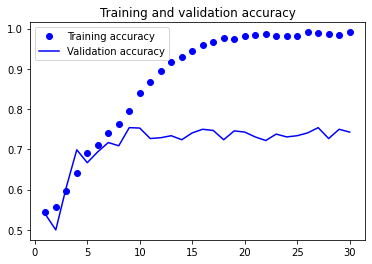

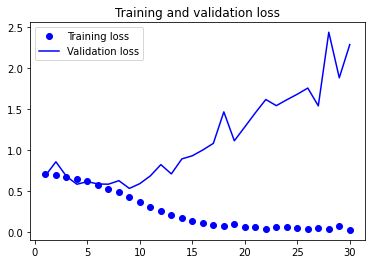

In [31]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

These plots are characteristic of overfitting. The training accuracy increases linearly over time, until it reaches nearly 100%, whereas the validation accuracy peaks at 75%. <br>
The validation loss reaches its minimum after only ten epochs and then stalls, whereas the training loss keeps decreasing linearly as training proceeds. <br>
Let’s check the test accuracy. We’ll **reload the model** from its saved file to evaluate it as it was **before it started overfitting**.

##### Evaluating the model on the test set

In [32]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 10s 151ms/step - loss: 0.5486 - accuracy: 0.7470
Test accuracy: 0.747


- We get a test accuracy of 74.1%. (Due to the randomness of neural network initializations, you may get numbers within one percentage point of that.)
- Because we have relatively **few training samples** (2,000), **overfitting** will be our number one concern. 
- You already know about a number of techniques that can help mitigate overfitting, such as **dropout** and weight decay **(L2 regularization)**. 
- We’re now going to work with a new one, specific to computer vision and used almost universally when processing images with deep learning models: **data augmentation**.

##### Using data augmentation
- Overfitting is caused by having too few samples to learn from, rendering you unable to train a model that can generalize to new data. 
- Given infinite data, your model would be exposed to every possible aspect of the data distribution at hand: you would never overfit. 
- Data augmentation takes the approach of generating more training data from existing training samples by **augmenting** the samples via a number of random transformations that yield believable-looking images. 
- The goal is that, at training time, your model will never see the exact same picture twice. 
  - This helps expose the model to more aspects of the data so it can generalize better.
- In Keras, this can be done by adding a number of **data augmentation** layers at the start of your model. 

Let’s get started with an example: the following Sequential model chains several random image transformations. In our model, we’d include it right before the **Rescaling** layer.

##### Define a data augmentation stage to add to an image model

In [33]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
])

These are just a few of the layers available (for more, see the Keras documentation). <br>
Let’s quickly go over this code:
- **RandomFlip("horizontal")**—Applies horizontal flipping to a random 50% of the images that go through it
- **RandomRotation(0.1)**—Rotates the input images by a random value in the range [–10%, +10%] (these are fractions of a full circle—in degrees, the range would be [–36 degrees, +36 degrees])
- **RandomZoom(0.2)**—Zooms in or out of the image by a random factor in the
range [-20%, +20%]

Let’s look at the augmented images.

##### Displaying some randomly augmented training images

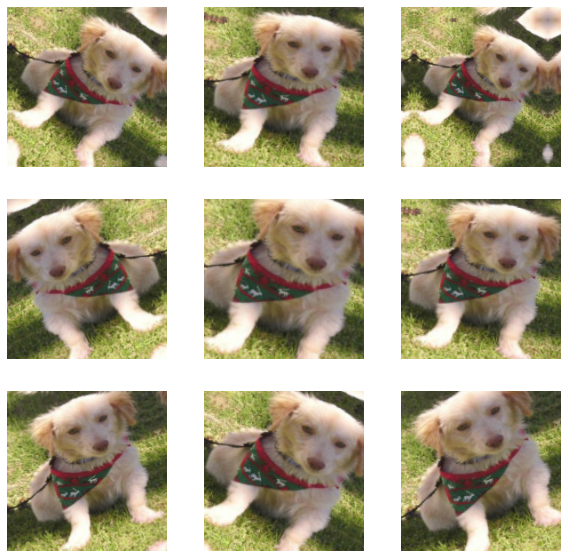

In [34]:
plt.figure(figsize=(10, 10))
# We can use take(N) to only sample N batches from the dataset. 
# This is equivalent to inserting a break in the loop after the Nth batch.
for images, _ in train_dataset.take(1):
    for i in range(9):
        # Apply the augmentation stage to the batch of images.
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1) # 3 rows, 3 columns, i+1th subplot
        # Display the first image in the output batch. 
        # For each of the nine iterations, this is a different augmentation of the same image.
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

- If we train a new model using this data-augmentation configuration, the model will never see the same input twice. 
- But the inputs it sees are still heavily intercorrelated because they come from a small number of original images—we can’t produce new information; we can only remix existing information. 
- As such, this may not be enough to completely get rid of overfitting. To further fight overfitting, we’ll also add a **Dropout** layer to our model right before the densely connected classifier.

One last thing you should know about random image augmentation layers: just like **Dropout**, they’re inactive during inference (when we call **predict()** or **evaluate()**). During evaluation, our model will behave just the same as when it did not include data augmentation and dropout.

##### Defining a new convnet that includes image augmentation and dropout

In [35]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

Let’s train the model using data augmentation and dropout. Because we expect overfitting to occur much later during training, we will train for three times as many epochs—one hundred.

##### Training the regularized convnet

In [36]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
63/63 [==============================] - 44s 673ms/step - loss: 0.8097 - accuracy: 0.5115 - val_loss: 0.6941 - val_accuracy: 0.5000
Epoch 2/100
63/63 [==============================] - 44s 693ms/step - loss: 0.7016 - accuracy: 0.5440 - val_loss: 0.6816 - val_accuracy: 0.5000
Epoch 3/100
63/63 [==============================] - 43s 688ms/step - loss: 0.6875 - accuracy: 0.5675 - val_loss: 0.6565 - val_accuracy: 0.6410
Epoch 4/100
63/63 [==============================] - 45s 713ms/step - loss: 0.6983 - accuracy: 0.6195 - val_loss: 0.8159 - val_accuracy: 0.5320
Epoch 5/100
63/63 [==============================] - 43s 690ms/step - loss: 0.6744 - accuracy: 0.6080 - val_loss: 1.4888 - val_accuracy: 0.5110
Epoch 6/100
63/63 [==============================] - 44s 691ms/step - loss: 0.6639 - accuracy: 0.6290 - val_loss: 0.6668 - val_accuracy: 0.5990
Epoch 7/100
63/63 [==============================] - 43s 688ms/step - loss: 0.6427 - accuracy: 0.6425 - val_loss: 0.6276 - val_accuracy:

Let’s plot the results again:

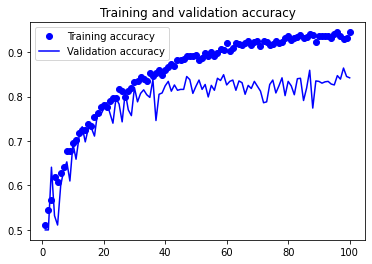

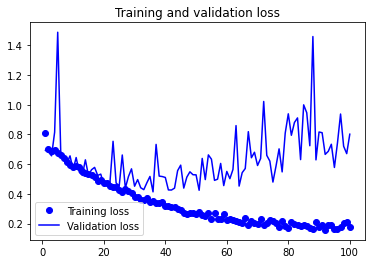

In [37]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Thanks to data augmentation and dropout, we start overfitting much later, around epochs 60–70 (compared to epoch 10 for the original model). The validation accuracy ends up consistently in the 80–85% range—a big improvement over our first try. <br>
Let’s check the test accuracy.

##### Evaluating the model on the test set

In [38]:
test_model = keras.models.load_model("convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 9s 141ms/step - loss: 0.4963 - accuracy: 0.8195
Test accuracy: 0.820


We get a test accuracy of 80.9%. It’s starting to look good! If you’re using Colab, make sure you download the saved file (convnet_from_scratch_with_augmentation.keras), as we will use it for some experiments in the next chapter.

By further tuning the model’s configuration (such as the number of filters per convolution layer, or the number of layers in the model), we might be able to get an even better accuracy, likely up to 90%. But it would prove difficult to go any higher just by training our own convnet from scratch, because we have so little data to work with. As a next step to improve our accuracy on this problem, we’ll have to use a **pretrained model**, which is the focus of the next two sections.

#### Leveraging a pretrained model
A common and highly effective approach to deep learning on small image datasets is to use a **pretrained model**. A **pretrained model** is a model that was previously trained on a large dataset, typically on a large-scale image-classification task. If this original dataset is large enough and general enough, the spatial hierarchy of features learned by the pretrained model can effectively act as a generic model of the visual world, and hence, its features can prove useful for many different computer vision problems, even though these new problems may involve completely different classes than those of the original task. For instance, you might train a model on ImageNet (where classes are mostly animals and everyday objects) and then repurpose this trained model for something as remote as identifying furniture items in images. Such portability of learned features across different problems is a key advantage of deep learning compared to many older, shallow learning approaches, and it makes deep learning very effective for small-data problems.

In this case, let’s consider a large convnet trained on the **ImageNet** dataset (1.4 million labeled images and 1,000 different classes). **ImageNet** contains many animal classes, including different species of cats and dogs, and you can thus expect it to perform well on the dogs-versus-cats classification problem.

We’ll use the **VGG16** architecture, developed by Karen Simonyan and Andrew Zisserman in 2014.1 Although it’s an older model, far from the current state of the art and somewhat heavier than many other recent models, I chose it because its architecture is similar to what you’re already familiar with, and it’s easy to understand without introducing any new concepts. This may be your first encounter with one of these cutesy model names—VGG, ResNet, Inception, Xception, and so on; you’ll get used to them because they will come up frequently if you keep doing deep learning for computer vision.

There are two ways to use a pretrained model: **feature extraction** and **fine-tuning**. <br>
We’ll cover both of them. Let’s start with **feature extraction**.

##### Feature extraction with a pretrained model
Feature extraction consists of using the representations learned by a previously trained model to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch. <br>
As you saw previously, convnets used for image classification comprise two parts: they start with a series of pooling and convolution layers, and they end with a densely connected classifier. The first part is called the **convolutional base** of the model. In the case of convnets, **feature extraction** consists of taking the convolutional base of a previously trained network, running the new data through it, and training a new classifier on top of the output (see figure 8.12).

![](./images/8.12.png)

- Why only reuse the convolutional base? Could we reuse the densely connected classifier as well? 
- In general, doing so should be avoided. 
  - The reason is that the representations learned by the convolutional base are likely to be more generic and, therefore, more reusable: the feature maps of a convnet are presence maps of generic concepts over a picture, which are likely to be useful regardless of the computer vision problem at hand. 
  - But the representations learned by the classifier will necessarily be specific to the set of classes on which the model was trained—they will only contain information about the presence probability of this or that class in the entire picture.
- Additionally, representations found in densely connected layers no longer contain any information about where objects are located in the input image; these layers get rid of the notion of space, whereas the object location is still described by convolutional feature maps. 
- For problems where object location matters, densely connected features are largely useless.
- Note that the level of generality (and therefore reusability) of the representations extracted by specific convolution layers depends on the depth of the layer in the model. 
- **Layers that come earlier in the model** extract local, highly generic feature maps (such as **visual edges, colors, and textures**), whereas layers that are **higher up extract more-abstract concepts (such as “cat ear” or “dog eye”**). 
- So **if your new dataset differs a lot from the dataset on which the original model was trained, you may be better off using only the first few layers of the model to do feature extraction**, rather than using the entire convolutional base.
- In this case, because the **ImageNet** class set contains multiple dog and cat classes, it’s likely to be beneficial to reuse the information contained in the densely connected layers of the original model. 
- But we’ll choose not to, in order to cover the more general case where the class set of the new problem doesn’t overlap the class set of the original model. 
- Let’s put this into practice by using the convolutional base of the **VGG16** network, trained on **ImageNet**, to extract interesting features from cat and dog images, and then train a dogs-versus-cats classifier on top of these features.

The **VGG16** model, among others, comes prepackaged with Keras. You can import it from the **keras.applications** module. Many other image-classification models (all pretrained on the **ImageNet** dataset) are available as part of **keras.applications**:
- Xception
- ResNet
- MobileNet
- EfficientNet
- DenseNet
- etc.

Let’s instantiate the VGG16 model.

##### Instantiating the VGG16 convolutional base

In [39]:
from tensorflow import keras
from tensorflow.keras import layers

conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

We pass three arguments to the constructor:
- **weights** specifies the weight checkpoint from which to initialize the model.
- **include_top** refers to including (or not) the densely connected classifier on top of the network. 
  - By default, this densely connected classifier corresponds to the 1,000 classes from ImageNet. 
  - Because we intend to use our own densely connected classifier (with only two classes: cat and dog), we don’t need to include it.
- **input_shape** is the shape of the image tensors that we’ll feed to the network.
  - This argument is purely **optional**: if we don’t pass it, the network will be able to process inputs of any size. 
  - Here we pass it so that we can visualize (in the following summary) how the size of the feature maps shrinks with each new convolution and pooling layer.

Here’s the detail of the architecture of the VGG16 convolutional base. It’s similar to the simple convnets you’re already familiar with:

In [40]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

The final feature map has shape (5, 5, 512). That’s the feature map on top of which we’ll stick a densely connected classifier. <br>
At this point, there are two ways we could proceed:
- Run the convolutional base over our dataset, record its output to a NumPy array on disk, and then use this data as input to a standalone, densely connected classifier similar to those you saw in chapter 4 of this book. 
  - This solution is fast and cheap to run, because it only requires running the convolutional base once for every input image, and the convolutional base is by far the most expensive part of the pipeline. 
  - But for the same reason, this technique **won’t allow us to use data augmentation**.
- Extend the model we have (**conv_base**) by adding **Dense** layers on top, and run the whole thing from end to end on the input data. 
  - **This will allow us to use data augmentation**, because every input image goes through the convolutional base every time it’s seen by the model. 
  - But for the same reason, this technique is far more expensive than the first.

We’ll cover both techniques. <br>
**Let’s walk through the code required to set up the first one:** recording the output of **conv_base** on our data and using these outputs as inputs to a new model.

##### FAST FEATURE EXTRACTION WITHOUT DATA AUGMENTATION
We’ll start by extracting features as NumPy arrays by calling the **predict()** method of the **conv_base** model on our training, validation, and testing datasets. <br>
Let’s iterate over our datasets to extract the VGG16 features.

##### Extracting the VGG16 features and corresponding labels

In [41]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)

- Importantly, **predict()** only expects images, not labels, but our current dataset yields batches that contain both images and their labels. 
- Moreover, the **VGG16** model expects inputs that are preprocessed with the function **keras.applications.vgg16.preprocess_input**, which scales pixel values to an appropriate range.

The extracted features are currently of shape (**samples, 5, 5, 512**):

In [42]:
train_features.shape

(2000, 5, 5, 512)

At this point, we can define our densely connected classifier (note the use of dropout for regularization) and train it on the data and labels that we just recorded.

##### Defining and training the densely connected classifier

In [43]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs) # Note the use of the Flatten layer before passing the features to a Dense layer.
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]

history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks
)

Epoch 1/20
63/63 [==============================] - 2s 31ms/step - loss: 11.1810 - accuracy: 0.9245 - val_loss: 11.9487 - val_accuracy: 0.9360
Epoch 2/20
63/63 [==============================] - 2s 31ms/step - loss: 4.0166 - accuracy: 0.9750 - val_loss: 5.1851 - val_accuracy: 0.9620
Epoch 3/20
63/63 [==============================] - 2s 31ms/step - loss: 2.0794 - accuracy: 0.9870 - val_loss: 3.5690 - val_accuracy: 0.9770
Epoch 4/20
63/63 [==============================] - 2s 29ms/step - loss: 1.4759 - accuracy: 0.9895 - val_loss: 4.2466 - val_accuracy: 0.9780
Epoch 5/20
63/63 [==============================] - 2s 30ms/step - loss: 0.8637 - accuracy: 0.9930 - val_loss: 5.7033 - val_accuracy: 0.9720
Epoch 6/20
63/63 [==============================] - 2s 29ms/step - loss: 0.3850 - accuracy: 0.9970 - val_loss: 5.2088 - val_accuracy: 0.9720
Epoch 7/20
63/63 [==============================] - 2s 28ms/step - loss: 0.7392 - accuracy: 0.9935 - val_loss: 5.6375 - val_accuracy: 0.9720
Epoch 8/20


Training is very fast because we only have to deal with two **Dense** layers—an epoch takes around 1 to 2 seconds even on CPU. <br>
Let’s look at the loss and accuracy curves during training.

##### Plotting the results

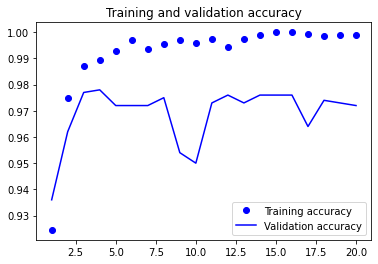

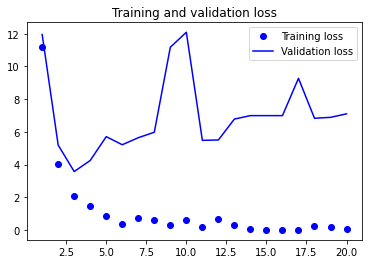

In [44]:
import matplotlib.pyplot as plt

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

We reach a validation accuracy of about 97%—much better than we achieved in the previous section with the small model trained from scratch. This is a bit of an unfair comparison, however, because ImageNet contains many dog and cat instances, which means that our pretrained model already has the exact knowledge required for the task at hand. This won’t always be the case when you use pretrained features.

However, the plots also indicate that we’re **overfitting** almost from the start—despite using dropout with a fairly large rate. **That’s because this technique doesn’t use data augmentation**, which is essential for preventing overfitting with small image datasets.

##### FEATURE EXTRACTION TOGETHER WITH DATA AUGMENTATION
Now let’s review the second technique I mentioned for doing feature extraction, which is much slower and more expensive, but which allows us to use data augmentation during training: creating a model that chains the **conv_base** with a new dense classifier, and training it end to end on the inputs.
- In order to do this, we will first **freeze the convolutional base**. 
- **Freezing** a layer or set of layers means preventing their weights from being updated during training. 
- If we don’t do this, the representations that were previously learned by the convolutional base will be modified during training. 
- Because the Dense layers on top are randomly initialized, very large weight updates would be propagated through the network, effectively destroying the representations previously learned.

In Keras, we freeze a layer or model by setting its **trainable** attribute to **False**.

##### Instantiating and freezing the VGG16 convolutional base

In [45]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False
)
conv_base.trainable = False

Setting **trainable** to **False** empties the list of trainable weights of the layer or model.

##### Printing the list of trainable weights before and after freezing

In [46]:
conv_base.trainable = True
print(f"This is the number of trainable weights before freezing the conv base: {len(conv_base.trainable_weights)}")

This is the number of trainable weights before freezing the conv base: 26


In [47]:
conv_base.trainable = False
print(f"This is the number of trainable weights after freezing the conv base: {len(conv_base.trainable_weights)}")

This is the number of trainable weights after freezing the conv base: 0


Now we can create a new model that chains together
1. A data augmentation stage
2. Our frozen convolutional base
3. A dense classifier

##### Adding a data augmentation stage and a classifier to the convolutional base

In [48]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs) # Apply data augmentation.
x = keras.applications.vgg16.preprocess_input(x) # Apply input value scaling.
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

- With this setup, only the weights from the two **Dense** layers that we added will be trained. 
- That’s a total of four weight tensors: two per layer (the main weight matrix and the bias vector). 
- Note that in order for these changes to take effect, **you must first compile the model**. 
- If you ever modify weight trainability after compilation, you should then recompile the model, or these changes will be ignored.

Let’s train our model. Thanks to data augmentation, it will take much longer for the model to start overfitting, so we can train for more epochs—let’s do 50.

> **NOTE** This technique is expensive enough that you should only attempt it if you have access to a GPU (such as the free GPU available in Colab)—it’s intractable on CPU. If you can’t run your code on GPU, then the previous technique is the way to go.

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Let’s plot the results again (see figure 8.14). As you can see, we reach a validation accuracy of over 98%. This is a strong improvement over the previous model.

![](./images/8.14.png)

Let’s check the test accuracy.

In [ ]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

- We get a test accuracy of 97.5%. 
- This is only a modest improvement compared to the previous test accuracy, which is a bit disappointing given the strong results on the validation data. 
- A model’s accuracy always depends on the set of samples you evaluate it on! 
- Some sample sets may be more difficult than others, and strong results on one set won’t necessarily fully translate to all other sets.

#### Fine-tuning a pretrained model
Another widely used technique for model reuse, complementary to feature extraction, is **fine-tuning** (see figure 8.15). 
- **Fine-tuning** consists of unfreezing a few of the top layers of a frozen model base used for feature extraction, and jointly training both the newly added part of the model (in this case, the fully connected classifier) and these top layers. 
- This is called **fine-tuning** because it slightly adjusts the more abstract representations of the model being reused in order to make them more relevant for the problem at hand.

- I stated earlier that it’s necessary to freeze the convolution base of VGG16 in order to be able to train a randomly initialized classifier on top. 
- For the same reason, it’s only possible to fine-tune the top layers of the convolutional base once the classifier on top has already been trained. 
- If the classifier isn’t already trained, the error signal propagating through the network during training will be too large, and the representations previously learned by the layers being fine-tuned will be destroyed. 
- Thus the steps for fine-tuning a network are as follows:
  - Add our custom network on top of an already-trained base network.
  - Freeze the base network.
  - Train the part we added.
  - Unfreeze some layers in the base network. (Note that you should not unfreeze “batch normalization” layers, which are not relevant here since there are no such layers in VGG16. Batch normalization and its impact on finetuning is explained in the next chapter.)
  - Jointly train both these layers and the part we added.

![](./images/8.15.png)

You already completed the first three steps when doing feature extraction. Let’s proceed with step 4: we’ll unfreeze our **conv_base** and then freeze individual layers inside it.

As a reminder, this is what our convolutional base looks like:

In [49]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

We’ll fine-tune the last three convolutional layers, which means all layers up to block4_pool should be frozen, and the layers block5_conv1, block5_conv2, and block5_conv3 should be trainable.

Why not fine-tune more layers? Why not fine-tune the entire convolutional base? <br>
You could. But you need to consider the following:
- Earlier layers in the convolutional base encode more generic, reusable features, whereas layers higher up encode more specialized features. It’s more useful to fine-tune the more specialized features, because these are the ones that need to be repurposed on your new problem. There would be fast-decreasing returns in fine-tuning lower layers.
- The more parameters you’re training, the more you’re at risk of overfitting. The convolutional base has 15 million parameters, so it would be risky to attempt to train it on your small dataset.

Thus, in this situation, it’s a good strategy to fine-tune only the top two or three layers in the convolutional base. Let’s set this up, starting from where we left off in the previous example.

##### Freezing all layers until the fourth from the last

In [50]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

Now we can begin fine-tuning the model. 
- We’ll do this with the RMSprop optimizer, using a very low learning rate. 
- The reason for using a low learning rate is that we want to limit the magnitude of the modifications we make to the representations of the three layers we’re fine-tuning. 
- Updates that are too large may harm these representations.

##### Fine-tuning the model

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

We can finally evaluate this model on the test data:

In [ ]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

Here, we get a test accuracy of 98.5% (again, your own results may be within one percentage point). In the original Kaggle competition around this dataset, this would have been one of the top results. It’s not quite a fair comparison, however, since we used pretrained features that already contained prior knowledge about cats and dogs, which competitors couldn’t use at the time. <br>
On the positive side, by leveraging modern deep learning techniques, we managed to reach this result using only a small fraction of the training data that was available for the competition (about 10%). There is a huge difference between being able to train on 20,000 samples compared to 2,000 samples!

Now you have a solid set of tools for dealing with image-classification problems—in particular, with small datasets.

#### Summary
- Convnets are the best type of machine learning models for computer vision tasks. It’s possible to train one from scratch even on a very small dataset, with decent results.
- Convnets work by learning a hierarchy of modular patterns and concepts to represent the visual world.
- On a small dataset, overfitting will be the main issue. Data augmentation is a powerful way to fight overfitting when you’re working with image data.
- It’s easy to reuse an existing convnet on a new dataset via feature extraction. This is a valuable technique for working with small image datasets.
- As a complement to feature extraction, you can use fine-tuning, which adapts to a new problem some of the representations previously learned by an existing model. This pushes performance a bit further.